In [2]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from typing import List, Tuple, Dict

# ==============================================================================
# 1. CONFIGURATION PARAMETERS
# ==============================================================================
CONFIG = {
    "hbar": 1,
    "scale": None,
    "epsilons": [0.10033534773107562, 0.06, 0.2, 5],
    "quad_range": (-6, 6),
    "quad_points": 200,
    "cmap": plt.cm.RdBu,
    "colors": {
        "q_marginal": "navy",
        "p_marginal": "maroon",
        "samples_x": "skyblue",
        "samples_p": "lightcoral",
        "ideal": "red",
        "noisy": "green"
    }
}
sf.hbar = CONFIG["hbar"]
CONFIG["scale"] = np.sqrt(CONFIG["hbar"] * np.pi)

# ==============================================================================
# 2. CORE SIMULATION FUNCTIONS
# ==============================================================================
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def simulate_gkp(
    prep_state:List[float],
    epsilons: List[float],
    noise_params: Dict = None,
    num_samples: int = 1
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Simulate GKP states with optional noise channels
    """
    noise_params = noise_params or {}
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    
    wigners, marginals_q, marginals_p = [], [], []
    
    for epsilon in epsilons:
        print(f"Processing ε={epsilon}...")
        avg_wigner = np.zeros((len(quad), len(quad)))
        
        for _ in range(num_samples):
            prog = sf.Program(1)
            with prog.context as q:
                # State preparation
                sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
                
                # Apply noise channels
                if 'loss' in noise_params:
                    sf.ops.LossChannel(noise_params['loss']) | q
                if 'gamma' in noise_params:
                    theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                    sf.ops.Rgate(theta) | q
                
            eng = sf.Engine("bosonic")
            state = eng.run(prog).state
            
            # Wigner function
            if num_samples > 1:
                avg_wigner += state.wigner(0, quad, quad)
            else:
                avg_wigner = state.wigner(0, quad, quad)
        
        # Store results
        wigners.append(avg_wigner/num_samples if num_samples>1 else avg_wigner)
        marginals_q.append(state.marginal(0, quad, phi=0))
        marginals_p.append(state.marginal(0, quad, phi=np.pi/2))
        
    return wigners, marginals_q, marginals_p

def simulate_homodyne(
    prep_state : List[float],
    epsilon: float,
    noise_params: Dict,
    num_samples: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate homodyne measurement with noise
    """
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    samples_x, samples_p = [], []
    
    for _ in range(num_samples):
        # X quadrature
        prog_x = sf.Program(1)
        with prog_x.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureX | q
        samples_x.append(sf.Engine("bosonic").run(prog_x).samples[0,0]/CONFIG["scale"])
        
        # P quadrature
        prog_p = sf.Program(1)
        with prog_p.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureP | q
        samples_p.append(sf.Engine("bosonic").run(prog_p).samples[0,0]/CONFIG["scale"])
    
    return np.array(samples_x), np.array(samples_p)

# Prepare GKP + channel => Wigner tomography
def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0,5.0),
    range_p=(-5.0,5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state), apply pure-loss channel(eta),
    then approximate the dephasing channel by integrating over many rotation angles
    phi ~ Normal(0, gamma). Returns a 2D Wigner array of shape (q_pts, q_pts).
    """
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, skip the rotation sampling
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0]  # step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis/phi_std)**2)
    w_phi /= (phi_std * np.sqrt(2*np.pi))  # normalization

    W_accum = np.zeros((q_pts, q_pts), dtype=float)
    for i, phi_val in enumerate(phis):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        W_accum += w_phi[i]*W_phi

    # Multiply by dphi to approximate integral
    return W_accum * dphi

# ==============================================================================
# 3. VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_wigner_marginals(
    wigners: List[np.ndarray],
    marginals_q: List[np.ndarray],
    marginals_p: List[np.ndarray],
    title: str = "",
    figsize: Tuple[float, float] = (14, 12)
):
    """Plot 2x2 grid of Wigner functions with marginals"""
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    cmax = np.real_if_close(np.amax(np.array(wigners)))
    norm = colors.Normalize(vmin=-cmax, vmax=cmax)
    
    fig = plt.figure(figsize=figsize)
    outer = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.3)
    
    for idx in range(4):
        i, j = divmod(idx, 2)
        inner = outer[i,j].subgridspec(2, 2, width_ratios=[4,1], height_ratios=[1,4],
                                      wspace=0.05, hspace=0.05)
        
        ax_main = fig.add_subplot(inner[1,0])
        ax_top = fig.add_subplot(inner[0,0], sharex=ax_main)
        ax_right = fig.add_subplot(inner[1,1], sharey=ax_main)
        
        # Main Wigner plot
        ax_main.contourf(quad/CONFIG["scale"], quad/CONFIG["scale"], wigners[idx],
                        levels=60, cmap=CONFIG["cmap"], norm=norm)
        ax_main.set_xlabel(r"$q$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        ax_main.set_ylabel(r"$p$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        
        # Marginals
        ax_top.plot(quad/CONFIG["scale"], marginals_q[idx], color=CONFIG["colors"]["q_marginal"])
        ax_right.plot(marginals_p[idx], quad/CONFIG["scale"], color=CONFIG["colors"]["p_marginal"])
        
        ax_top.tick_params(labelbottom=False)
        ax_right.tick_params(labelleft=False)
    
    # Colorbar
    cax = fig.add_axes([0.93, 0.25, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(cmap=CONFIG["cmap"], norm=norm)
    fig.colorbar(sm, cax=cax).set_label("Wigner Function", fontsize=12)
    
    if title:
        fig.suptitle(title, y=0.95, fontsize=16)
    plt.show()

def plot_quadratures(
    samples_x: np.ndarray,
    samples_p: np.ndarray,
    noisy_x: np.ndarray,
    noisy_p: np.ndarray,
    title: str = "",
    noisy: bool = False,
    figsize: Tuple[float, float] = (12, 5)
):
    """Plot quadrature measurement results"""
    quad_axis = np.linspace(-6, 6, 1000)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    # X quadrature
    x_hist, x_bin_edges, _ = axs[0].hist(samples_x, bins=100, density=True, 
               color=CONFIG["colors"]["samples_x"], label="Samples")
    print("Number of bins in X histogram:", len(x_hist))
    # axs[0].plot(quad_axis, ideal_x, '--', color=CONFIG["colors"]["ideal"], label="Ideal")
    if noisy:
        axs[0].plot(quad_axis, noisy_x, '-', color=CONFIG["colors"]["noisy"], label="Noisy")
    axs[0].set_xlabel(r"$q$ ($\sqrt{\pi\hbar}$)", fontsize=12)
    axs[0].set_ylabel("Probability Density", fontsize=12)

    # Add bin overlays for X quadrature
    for j in range(-3, 4):
        axs[0].axvspan(2*j - 0.5, 2*j + 0.5, alpha=0.2, facecolor='b')
        axs[0].axvspan(2*j + 0.5, 2*j + 1.5, alpha=0.2, facecolor='r')
    
    # P quadrature
    p_hist, p_bin_edges, _ = axs[1].hist(samples_p, bins=100, density=True, 
               color=CONFIG["colors"]["samples_p"], label="Samples")
    # axs[1].plot(quad_axis, ideal_p, '--', color=CONFIG["colors"]["ideal"], label="Ideal")
    if noisy:
        axs[1].plot(quad_axis, noisy_p, '-', color=CONFIG["colors"]["noisy"], label="Noisy")
    axs[1].set_xlabel(r"$p$ ($\sqrt{\pi\hbar}$)", fontsize=12)

    # Add bin overlays for P quadrature
    for j in range(-3, 4):
        axs[1].axvspan(2*j - 0.5, 2*j + 0.5, alpha=0.2, facecolor='b')
        axs[1].axvspan(2*j + 0.5, 2*j + 1.5, alpha=0.2, facecolor='r')
    
    for ax in axs:
        ax.legend()
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

    return (x_hist, x_bin_edges), (p_hist, p_bin_edges)

def calculate_ideal_marginals(prep_state: List[float], epsilon: float) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate ideal marginal distributions"""
    prog = sf.Program(1)
    with prog.context as q:
        sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
    state = sf.Engine("bosonic").run(prog).state
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    return (
        state.marginal(0, quad_axis, phi=0) * CONFIG["scale"],
        state.marginal(0, quad_axis, phi=np.pi/2) * CONFIG["scale"]
    )

def calculate_noisy_marginals(prep_state: List[float], epsilon: float, noise_params: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate averaged noisy marginals"""
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    num_avg = 100
    marg_x, marg_p = np.zeros_like(quad_axis), np.zeros_like(quad_axis)
    
    for _ in range(num_avg):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                sf.ops.Rgate(theta) | q
        state = sf.Engine("bosonic").run(prog).state
        marg_x += state.marginal(0, quad_axis, phi=0)
        marg_p += state.marginal(0, quad_axis, phi=np.pi/2)
        
    return (marg_x/num_avg * CONFIG["scale"], marg_p/num_avg * CONFIG["scale"])


In [13]:
db = 14
ep = db_to_epsilon(db)
print(ep)

0.039831768989501665


### GKP qubit with varying epsilon
$\epsilon \in [0.05, 0.1, 0.2, 5]$

$\epsilon$ controls peaks width and envelope where  $(\kappa = tanh(\epsilon), r = -0.5 \times log(tanh(\epsilon)))$

Processing ε=0.10033534773107562...
Processing ε=0.06...
Processing ε=0.2...
Processing ε=5...


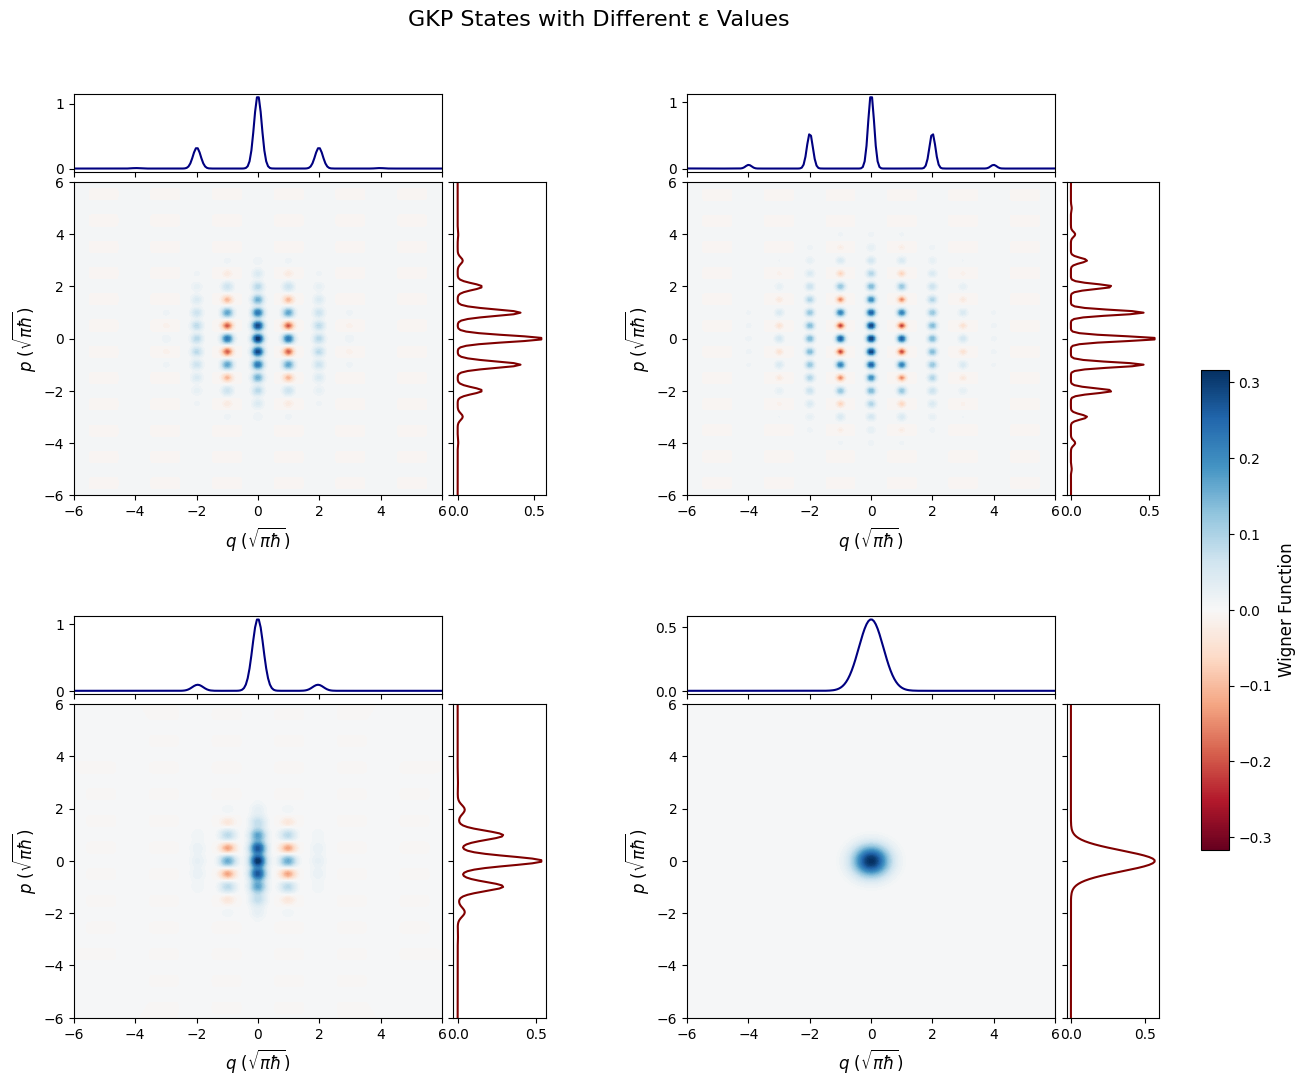

In [44]:
wigners, marginals_q, marginals_p = simulate_gkp(prep_state=[0,0], epsilons=CONFIG["epsilons"])
plot_wigner_marginals(wigners, marginals_q, marginals_p,
                    title="GKP States with Different ε Values")

### Pure Loss channel

Processing ε=0.10033534773107562...
Processing ε=0.06...
Processing ε=0.2...
Processing ε=5...


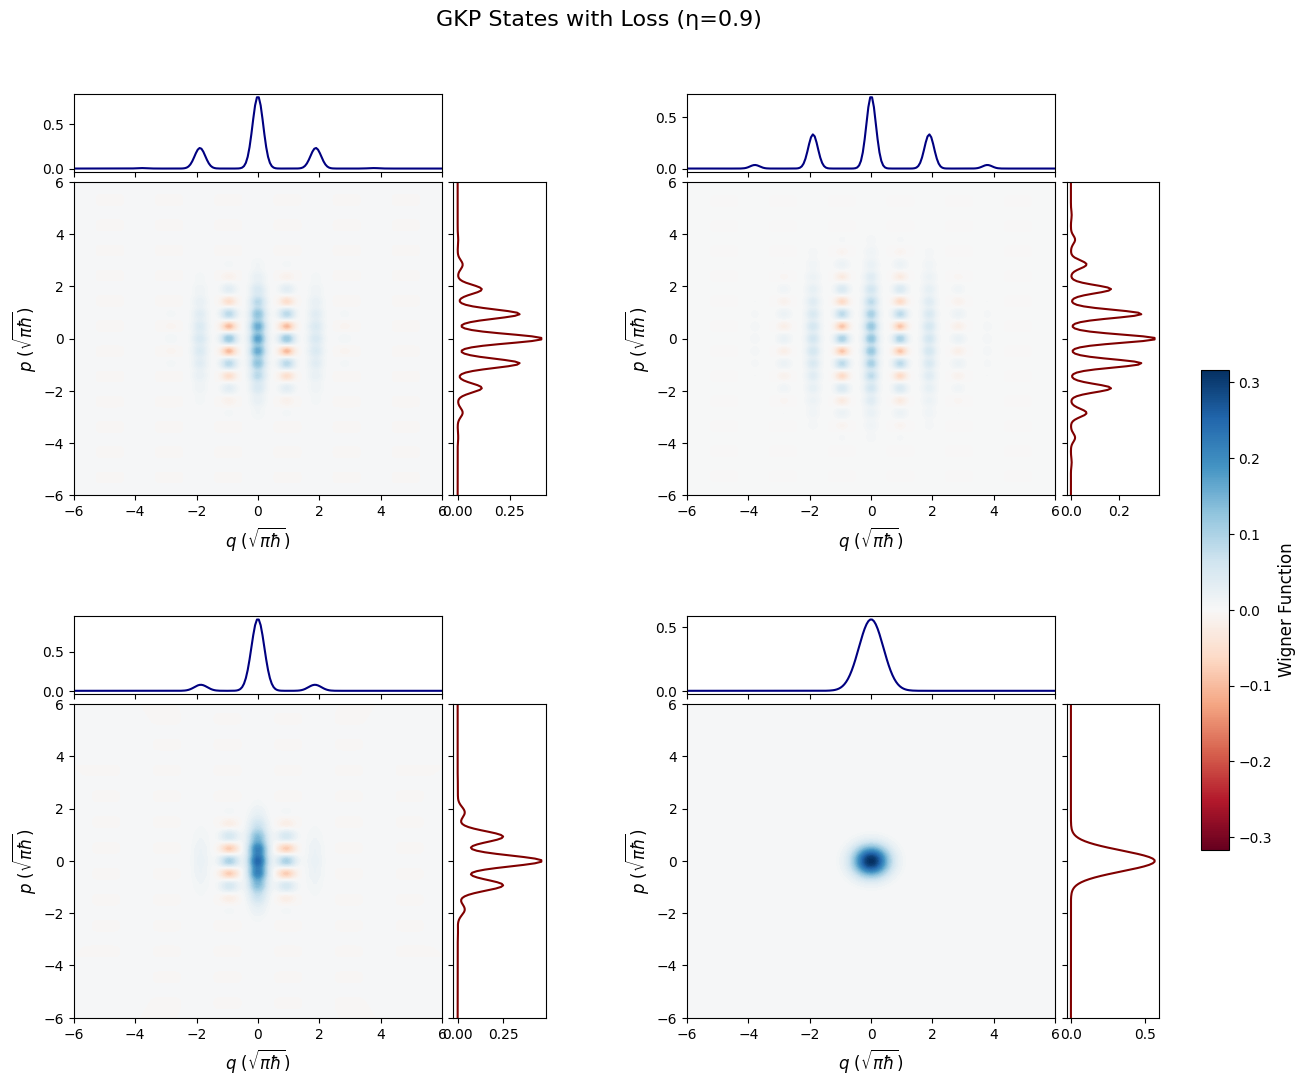

In [47]:
loss_params = {"loss": 0.9}
wigners_loss, marginals_q_loss, marginals_p_loss = simulate_gkp(prep_state=[0,0],
    epsilons=CONFIG["epsilons"], noise_params=loss_params)
plot_wigner_marginals(wigners_loss, marginals_q_loss, marginals_p_loss,
                    title=f"GKP States with Loss (η={loss_params['loss']})")

### Pure Dephasing channel

Processing ε=0.10033534773107562...
Processing ε=0.06...
Processing ε=0.2...
Processing ε=5...


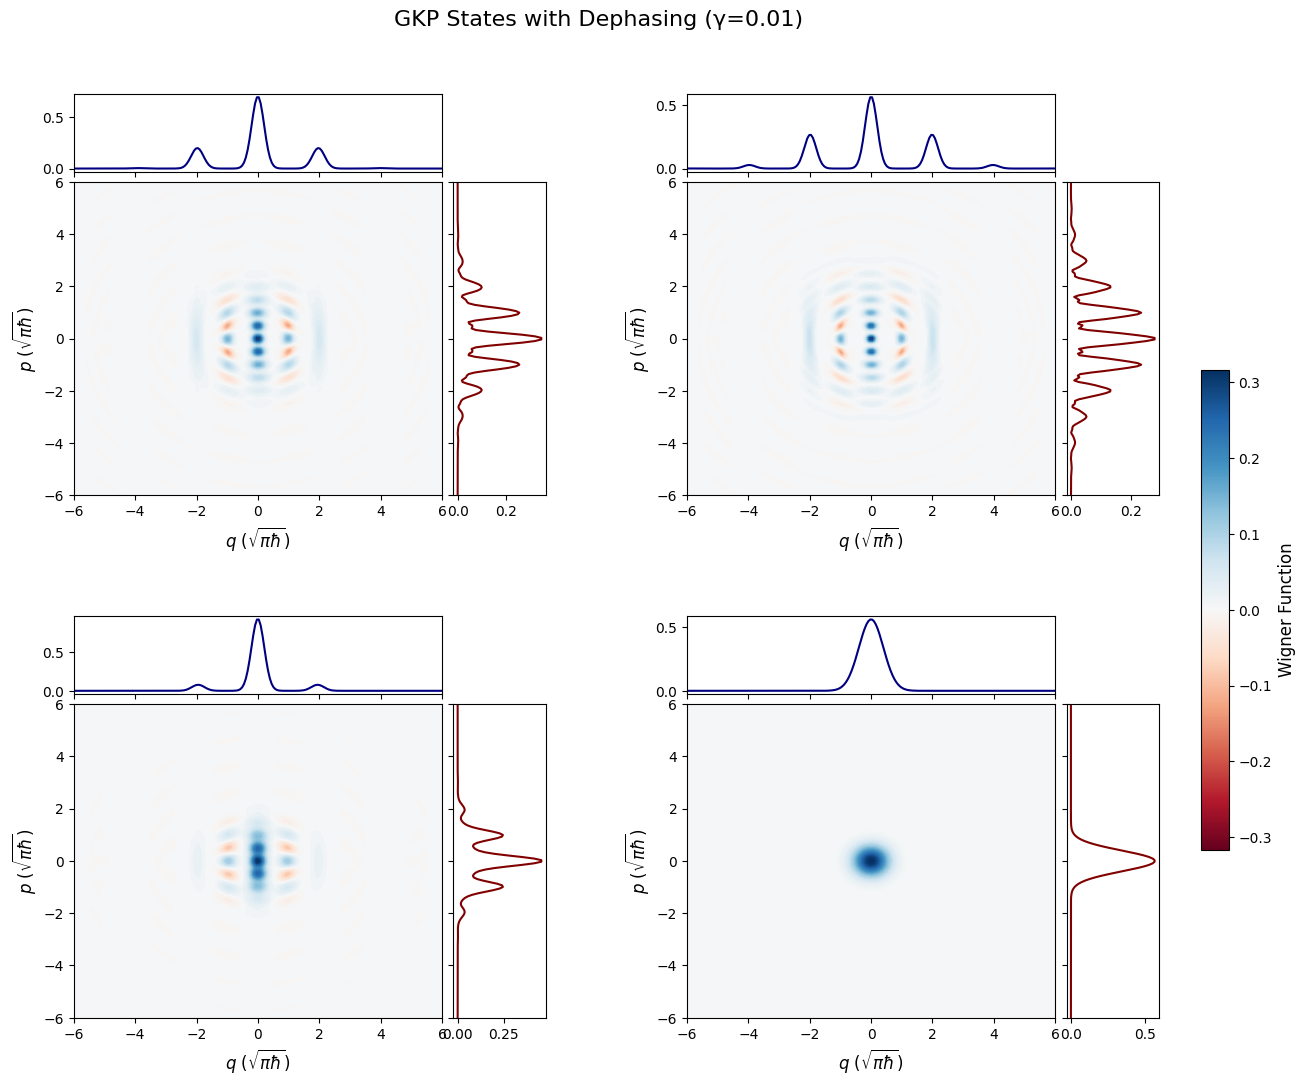

In [48]:
dephasing_params = {"gamma": 0.01}  # dephasing strength

# Simulate with 100 noise samples
wigners_dephasing, marginals_q_dephasing, marginals_p_dephasing = simulate_gkp(
    prep_state=[0,0],
    epsilons=CONFIG["epsilons"],
    noise_params=dephasing_params,
    num_samples=1000
)

# Plot
plot_wigner_marginals(wigners_dephasing, marginals_q_dephasing, marginals_p_dephasing,
                     title=f"GKP States with Dephasing (γ={dephasing_params['gamma']})")



### Loss-Dephasing Channel

Processing ε=0.10033534773107562...
Processing ε=0.06...
Processing ε=0.2...
Processing ε=5...


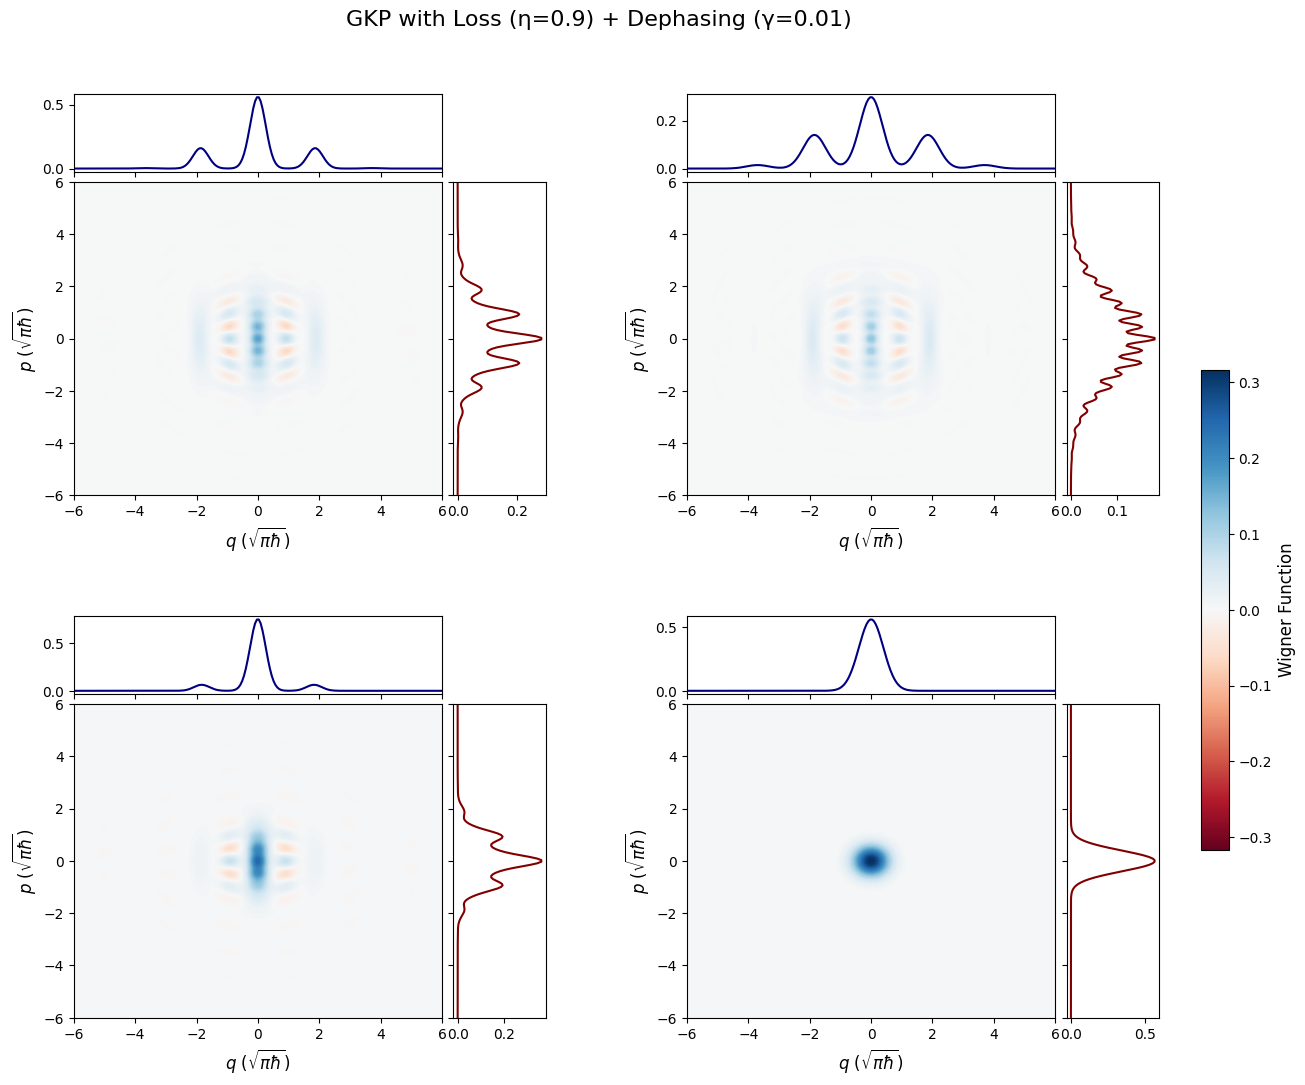

In [49]:
combined_noise_params = {
    "loss": 0.9,    # loss
    "gamma": 0.01   # Dephasing strength
}

# Simulate with 100 noise samples
wigners_combined, marginals_q_combined, marginals_p_combined = simulate_gkp(
    prep_state=[0,0],
    epsilons=CONFIG["epsilons"],
    noise_params=combined_noise_params,
    num_samples=1000
)

# Plot
plot_wigner_marginals(wigners_combined, marginals_q_combined, marginals_p_combined,
                     title=f"GKP with Loss (η={combined_noise_params['loss']}) + Dephasing (γ={combined_noise_params['gamma']})")


### Homodyne Detection

In [ ]:
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

homodyne_params = {
    "loss": 0.91578947,    #  loss
    "gamma": 0.010526316   # Dephasing strength
}
num_shots = 3000    # Number of measurement samples

for epsilon in CONFIG["epsilons"]:
    # Get measurement samples
    samples_x, samples_p = simulate_homodyne(
        prep_state=[0,0],
        epsilon=epsilon,
        noise_params=homodyne_params,
        num_samples=num_shots
    )

    print(samples_x, samples_p)
    
    # Calculate ideal/noisy distributions (needs implementation)
    ideal_x, ideal_p = calculate_ideal_marginals(prep_state=[0,0], epsilon= epsilon)
    noisy_x, noisy_p = calculate_noisy_marginals(prep_state=[0,0],epsilon=epsilon, noise_params=homodyne_params)
    
    # Plot results
    (x_hist, x_bin_edges), (p_hist, p_bin_edges) = plot_quadratures(
        samples_x, samples_p,
        noisy_x, noisy_p,
        title=f"ε={epsilon} Homodyne Measurements with Noise",
        noisy = True
    )

    

KeyboardInterrupt: 

Number of bins in X histogram: 100


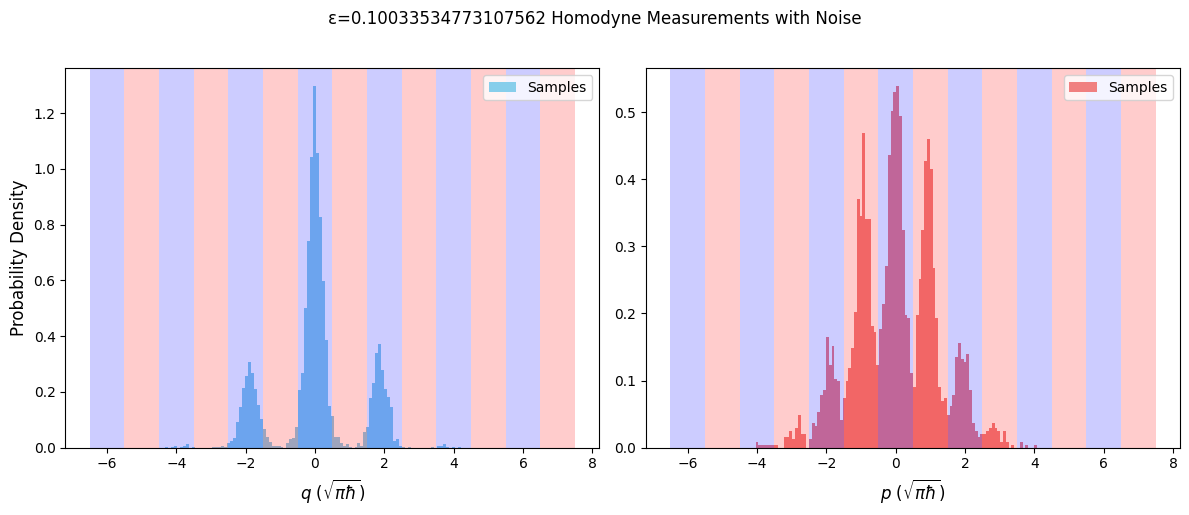

((array([0.00390532, 0.        , 0.00390532, 0.00781064, 0.        ,
         0.00390532, 0.00781064, 0.01171596, 0.        , 0.00390532,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.00390532, 0.00390532, 0.00390532, 0.00781064,
         0.00390532, 0.01562128, 0.02343192, 0.03514789, 0.0937277 ,
         0.14449687, 0.21479265, 0.25775117, 0.30852035, 0.26946714,
         0.21088732, 0.15230751, 0.10153834, 0.06639045, 0.03905321,
         0.0195266 , 0.00781064, 0.00781064, 0.00781064, 0.00390532,
         0.        , 0.01562128, 0.03124257, 0.03514789, 0.0742011 ,
         0.206982  , 0.26946714, 0.49988107, 0.74201096, 1.04272066,
         1.29656652, 1.05834195, 0.82792802, 0.59751409, 0.38662676,
         0.14840219, 0.1132543 , 0.03905321, 0.03905321, 0.01562128,
         0.00781064, 0.01171596, 0.00390532, 0.        , 0.00390532,
         0.01562128, 0.00781064, 0.05467449, 0.0742011 , 0.17964476,
         0.23041393, 0.33976291, 0

In [38]:
# Define quad_axis similar to the one used in calculate_noisy_marginals:

homodyne_params = {
    "loss": 0.9,    #  loss
    "gamma": 0.01  # Dephasing strength
}
num_shots = 3000    # Number of measurement samples

epsilon = db_to_epsilon(10)

samples_x, samples_p = simulate_homodyne(
    prep_state=[0,0],
    epsilon=epsilon,
    noise_params=homodyne_params,
    num_samples=num_shots
)


# Calculate ideal/noisy distributions (needs implementation)
ideal_x, ideal_p = calculate_ideal_marginals(prep_state=[0,0], epsilon= epsilon)
noisy_x, noisy_p = calculate_noisy_marginals(prep_state=[0,0],epsilon=epsilon, noise_params=homodyne_params)

# Plot results
plot_quadratures(
        samples_x, samples_p,
        noisy_x, noisy_p,
        title=f"ε={epsilon} Homodyne Measurements with Noise",
        noisy = False
    )

# print("X Histogram", x_hist)
# print("P Histogram", p_hist)


(3000,)


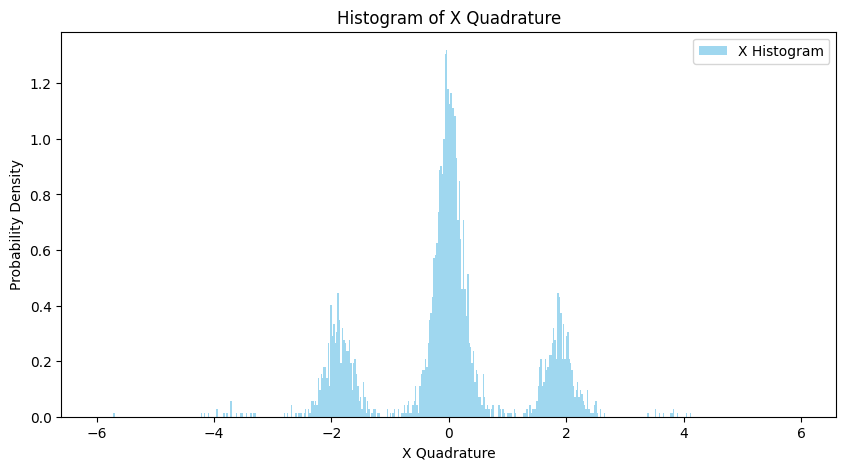

In [ ]:

print(samples_x.shape)
x_hist, x_bin_edges = np.histogram(samples_x, bins=500, range=(-6, 6), density=True)
bin_centers_x = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
bin_width_x = x_bin_edges[1] - x_bin_edges[0]

plt.figure(figsize=(10, 5))
plt.bar(bin_centers_x, x_hist, width=bin_width_x, alpha=0.8, color='skyblue', label="X Histogram")
plt.xlabel("X Quadrature")
plt.ylabel("Probability Density")
plt.title("Histogram of X Quadrature")
plt.legend()
plt.show()

P(l_i, d_j| M

(3000,)


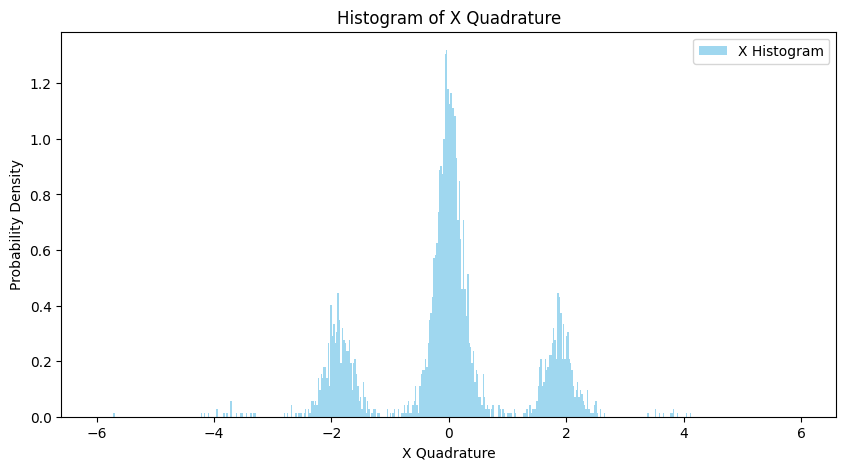

In [35]:

print(samples_x.shape)
x_hist, x_bin_edges = np.histogram(samples_x, bins=500, range=(-6, 6), density=True)
bin_centers_x = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
bin_width_x = x_bin_edges[1] - x_bin_edges[0]

plt.figure(figsize=(10, 5))
plt.bar(bin_centers_x, x_hist, width=bin_width_x, alpha=0.8, color='skyblue', label="X Histogram")
plt.xlabel("X Quadrature")
plt.ylabel("Probability Density")
plt.title("Histogram of X Quadrature")
plt.legend()
plt.show()

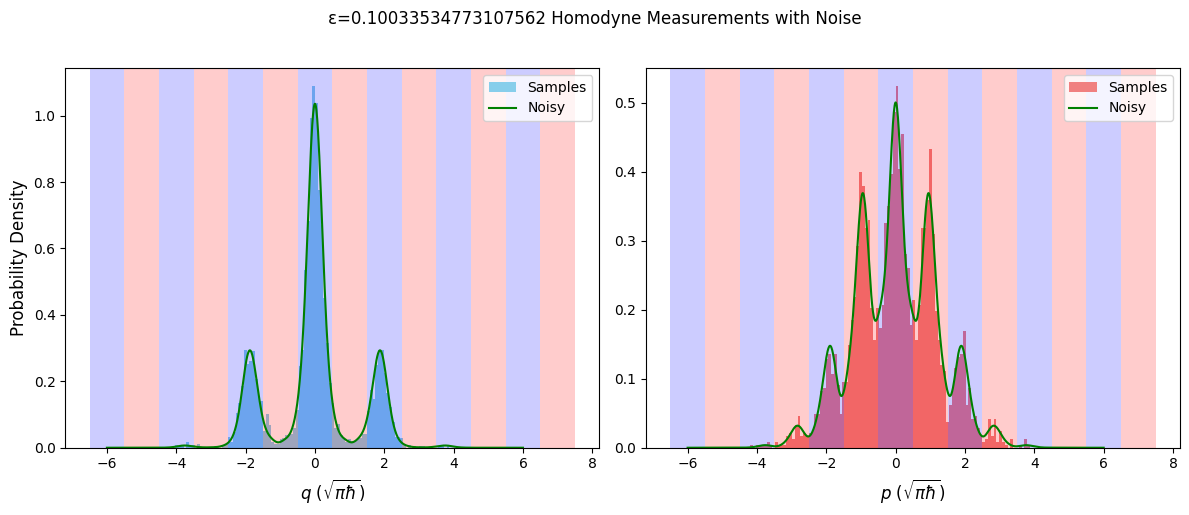

In [ ]:
homodyne_params = {
    "loss": 0.9,    #  loss
    "gamma": 0.02  # Dephasing strength
}
num_shots = 3000    # Number of measurement samples

epsilon = db_to_epsilon(10)

samples_x, samples_p = simulate_homodyne(
    prep_state=[0,0],
    epsilon=epsilon,
    noise_params=homodyne_params,
    num_samples=num_shots
)


# Calculate ideal/noisy distributions (needs implementation)
ideal_x, ideal_p = calculate_ideal_marginals(prep_state=[0,0], epsilon= epsilon)
noisy_x, noisy_p = calculate_noisy_marginals(prep_state=[0,0],epsilon=epsilon, noise_params=homodyne_params)

# Plot results
plot_quadratures(
    samples_x, samples_p,
    noisy_x, noisy_p,
    title=f"ε={epsilon} Homodyne Measurements with Noise"
)

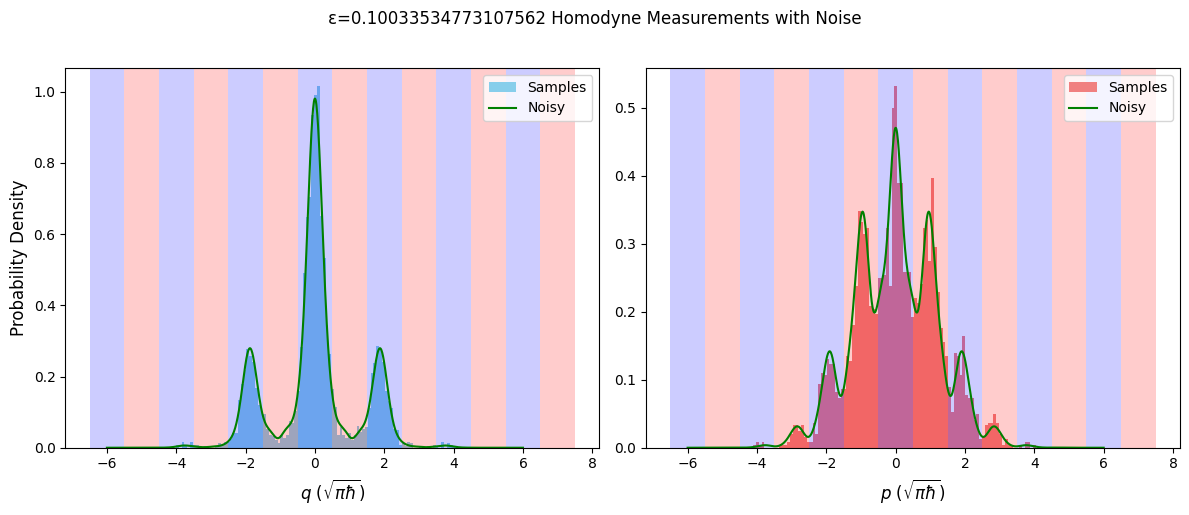

In [ ]:
homodyne_params = {
    "loss": 0.9,    #  loss
    "gamma": 0.03  # Dephasing strength
}
num_shots = 3000    # Number of measurement samples

epsilon = db_to_epsilon(10)

samples_x, samples_p = simulate_homodyne(
    prep_state=[0,0],
    epsilon=epsilon,
    noise_params=homodyne_params,
    num_samples=num_shots
)


# Calculate ideal/noisy distributions (needs implementation)
ideal_x, ideal_p = calculate_ideal_marginals(prep_state=[0,0], epsilon= epsilon)
noisy_x, noisy_p = calculate_noisy_marginals(prep_state=[0,0],epsilon=epsilon, noise_params=homodyne_params)

# Plot results
plot_quadratures(
    samples_x, samples_p,
    noisy_x, noisy_p,
    title=f"ε={epsilon} Homodyne Measurements with Noise"
)


=== EXAMPLE 3: Optimize LO phase for max FI wrt eta ===
mu=0.000 => FI=40.9494
mu=0.224 => FI=52.1219
mu=0.449 => FI=41.5784
mu=0.673 => FI=42.5700
mu=0.898 => FI=34.5807
mu=1.122 => FI=45.3997
mu=1.346 => FI=43.1646
mu=1.571 => FI=43.1886
mu=1.795 => FI=45.2243
mu=2.020 => FI=39.0841
mu=2.244 => FI=37.8442
mu=2.468 => FI=49.5759
mu=2.693 => FI=29.9768
mu=2.917 => FI=45.4238
mu=3.142 => FI=47.5064


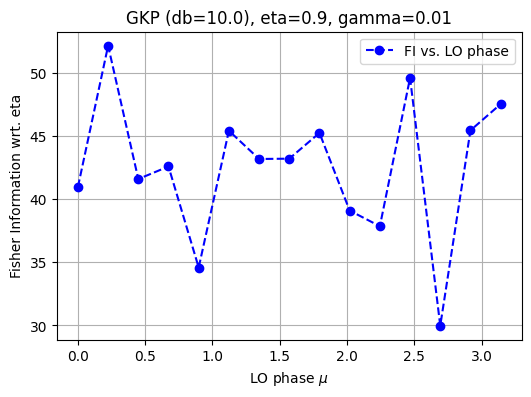


Best LO phase = 0.2244,  FI = 52.1219
Optimal mu => 0.2244, with FI => 52.1219


In [5]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import List, Tuple, Dict

##############################################################################
# 1. CONFIGURATION PARAMETERS
##############################################################################

CONFIG = {
    "hbar": 1,
    "scale": None,  # set below
    # example set of epsilons (some in actual numeric, others from your earlier code)
    "epsilons": [0.10033534773107562, 0.06, 0.2, 5],
    "quad_range": (-6, 6),
    "quad_points": 200,
    "cmap": plt.cm.RdBu,
    "colors": {
        "q_marginal": "navy",
        "p_marginal": "maroon",
        "samples_x": "skyblue",
        "samples_p": "lightcoral",
        "ideal": "red",
        "noisy": "green"
    }
}
sf.hbar = CONFIG["hbar"]
CONFIG["scale"] = np.sqrt(CONFIG["hbar"] * np.pi)

##############################################################################
# 2. HELPER FUNCTIONS
##############################################################################

def db_to_epsilon(db_val: float) -> float:
    """
    Convert a GKP squeezing level in dB to epsilon:
         tanh(epsilon) = 10^(-db_val/10).
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

##############################################################################
# 3. CORE SIMULATION: GKP + NOISE
##############################################################################

def simulate_gkp(
    prep_state: List[float],
    epsilons: List[float],
    noise_params: Dict = None,
    num_samples: int = 1
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Generate approximate GKP states at several 'epsilon' values,
    apply optional noise channels, and compute Wigner + marginals.
    
    :param prep_state: e.g. [1,0] => |0>, [0,1] => |1>.
    :param epsilons: list of epsilons (NOT dB).
    :param noise_params: e.g. {'loss': 0.9, 'gamma': 0.01}.
    :param num_samples: how many times to average Wigner if >1.
    :return: (list_of_Wigners, list_of_marginals_q, list_of_marginals_p).
    """
    noise_params = noise_params or {}
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    
    wigners, marginals_q, marginals_p = [], [], []
    
    for epsilon in epsilons:
        print(f"Processing ε={epsilon}...")
        avg_wigner = np.zeros((len(quad), len(quad)))
        
        for _ in range(num_samples):
            prog = sf.Program(1)
            with prog.context as q:
                # Prepare approximate GKP
                sf.ops.GKP(state=prep_state, epsilon=epsilon) | q[0]
                
                # Apply noise channels
                if 'loss' in noise_params:
                    sf.ops.LossChannel(noise_params['loss']) | q[0]
                if 'gamma' in noise_params:
                    theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                    sf.ops.Rgate(theta) | q[0]
            
            eng = sf.Engine("bosonic")
            state = eng.run(prog).state
            
            # Wigner function
            tmp_wigner = state.wigner(0, quad, quad)
            if num_samples > 1:
                avg_wigner += tmp_wigner
            else:
                avg_wigner = tmp_wigner
        
        # Store results: average if num_samples>1
        out_wigner = avg_wigner/num_samples if num_samples>1 else avg_wigner
        wigners.append(out_wigner)
        # Marginals
        marginals_q.append(state.marginal(0, quad, phi=0))
        marginals_p.append(state.marginal(0, quad, phi=np.pi/2))
        
    return wigners, marginals_q, marginals_p


def simulate_homodyne_phase(
    prep_state : List[float],
    epsilon: float,
    noise_params: Dict,
    mu: float,
    num_samples: int
) -> np.ndarray:
    """
    Simulate homodyne measurement of quadrature x_mu = q cos(mu) + p sin(mu)
    for a single-mode approximate GKP state with optional loss & dephasing.
    
    :param prep_state: e.g. [1, 0] => |0>.
    :param epsilon: GKP squeezing param (NOT in dB).
    :param noise_params: e.g. {'loss': 0.9, 'gamma': 0.01}.
    :param mu: local oscillator phase in [0, 2*pi).
    :param num_samples: number of shots.
    :return: array of measurement outcomes (length = num_samples).
    """
    samples = []
    for _ in range(num_samples):
        prog = sf.Program(1)
        with prog.context as q:
            # 1) Prepare GKP
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q[0]
            
            # 2) Noise
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q[0]
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2 * noise_params['gamma']))
                sf.ops.Rgate(theta) | q[0]
            
            # 3) Measure quadrature with LO phase mu
            sf.ops.MeasureHomodyne(phi=mu) | q[0]
        
        eng = sf.Engine("bosonic")
        result = eng.run(prog)
        val = result.samples[0, 0]
        samples.append(val)
    
    return np.array(samples)


##############################################################################
# 4. FISHER INFO ESTIMATION WRT ETA
##############################################################################

def estimate_fi_for_mu(
    prep_state: List[float],
    epsilon: float,
    eta0: float,
    delta_eta: float,
    gamma_deph: float,
    mu: float,
    num_samples: int = 20000,
    bins: int = 100,
    x_range: Tuple[float,float] = (-6,6),
) -> float:
    """
    Estimate classical Fisher Info wrt 'eta' at fixed LO phase mu,
    using a finite-difference approach with homodyne sampling.

    :param prep_state: e.g. [1,0] => GKP |0>.
    :param epsilon: GKP param (NOT dB).
    :param eta0: nominal transmissivity in [0,1].
    :param delta_eta: small offset for finite difference.
    :param gamma_deph: dephasing param.
    :param mu: local-oscillator phase in [0, 2*pi).
    :param num_samples: how many shots for each distribution.
    :param bins: histogram bins to approximate p(x).
    :param x_range: range for histogram.
    :return: estimated FI(eta0, mu).
    """
    # p_+(x) at (eta0 + delta_eta)
    noise_plus = {"loss": eta0 + delta_eta, "gamma": gamma_deph}
    x_plus = simulate_homodyne_phase(prep_state, epsilon, noise_plus, mu, num_samples)

    # p_-(x) at (eta0 - delta_eta)
    noise_minus = {"loss": eta0 - delta_eta, "gamma": gamma_deph}
    x_minus = simulate_homodyne_phase(prep_state, epsilon, noise_minus, mu, num_samples)

    # Convert samples to discrete probabilities
    counts_plus, bin_edges = np.histogram(x_plus, bins=bins, range=x_range, density=False)
    counts_minus, _ = np.histogram(x_minus, bins=bins, range=x_range, density=False)

    p_plus  = counts_plus  / np.sum(counts_plus)
    p_minus = counts_minus / np.sum(counts_minus)

    # midpoint & derivative
    p0 = 0.5*(p_plus + p_minus)
    dp = (p_plus - p_minus)/(2.0*delta_eta)

    # sum over i of [dp^2 / p0]
    eps_den = 1e-14
    mask = p0 > eps_den
    FI_val = np.sum( (dp[mask]**2) / p0[mask] )

    return FI_val


def optimize_lo_phase_for_fi(
    prep_state=[1.0, 0.0],
    epsilon_db=10.0,
    eta0=0.90,
    delta_eta=0.01,
    gamma_deph=0.01,
    num_samples=20000,
    bins=80
):
    """
    Scan LO phase mu from 0 to pi to find which angle maximizes Fisher Info wrt. eta.
    Plots FI vs. mu, returns the best mu.
    """
    epsilon_val = db_to_epsilon(epsilon_db)
    
    # e.g. 15 steps from 0 to pi
    mu_list = np.linspace(0, np.pi, 15)
    fi_vals = []
    
    for mu in mu_list:
        fi_mu = estimate_fi_for_mu(
            prep_state=prep_state,
            epsilon=epsilon_val,
            eta0=eta0,
            delta_eta=delta_eta,
            gamma_deph=gamma_deph,
            mu=mu,
            num_samples=num_samples,
            bins=bins,
            x_range=(-6,6)
        )
        fi_vals.append(fi_mu)
        print(f"mu={mu:.3f} => FI={fi_mu:.4f}")
    
    mu_arr = np.array(mu_list)
    fi_arr = np.array(fi_vals)
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(mu_arr, fi_arr, "o--", color="blue", label="FI vs. LO phase")
    plt.xlabel(r"LO phase $\mu$")
    plt.ylabel("Fisher Information wrt. eta")
    plt.title(f"GKP (db={epsilon_db}), eta={eta0}, gamma={gamma_deph}")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Argmax
    idx_best = np.argmax(fi_arr)
    best_mu = mu_arr[idx_best]
    best_fi = fi_arr[idx_best]
    print(f"\nBest LO phase = {best_mu:.4f},  FI = {best_fi:.4f}")
    
    return best_mu, best_fi


##############################################################################
# 5. OPTIONAL VISUALIZATION: WIGNER & HOMODYNE
##############################################################################

def plot_wigner_marginals(
    wigners: List[np.ndarray],
    marginals_q: List[np.ndarray],
    marginals_p: List[np.ndarray],
    title: str = "",
):
    """Plot 2x2 grid of Wigner functions with marginals for up to 4 states."""
    from matplotlib import colors
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    cmax = np.real_if_close(np.amax(np.array(wigners)))
    norm = colors.Normalize(vmin=-cmax, vmax=cmax)
    
    fig = plt.figure(figsize=(14, 12))
    outer = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.3)
    
    for idx in range(len(wigners)):
        i, j = divmod(idx, 2)
        inner = outer[i,j].subgridspec(2, 2, width_ratios=[4,1], height_ratios=[1,4],
                                      wspace=0.05, hspace=0.05)
        
        ax_main = fig.add_subplot(inner[1,0])
        ax_top = fig.add_subplot(inner[0,0], sharex=ax_main)
        ax_right = fig.add_subplot(inner[1,1], sharey=ax_main)
        
        # Main Wigner
        ax_main.contourf(quad/CONFIG["scale"], quad/CONFIG["scale"], wigners[idx],
                        levels=60, cmap=CONFIG["cmap"], norm=norm)
        ax_main.set_xlabel(r"$q$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        ax_main.set_ylabel(r"$p$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        
        # Marginals
        ax_top.plot(quad/CONFIG["scale"], marginals_q[idx], color=CONFIG["colors"]["q_marginal"])
        ax_right.plot(marginals_p[idx], quad/CONFIG["scale"], color=CONFIG["colors"]["p_marginal"])
        
        ax_top.tick_params(labelbottom=False)
        ax_right.tick_params(labelleft=False)
    
    # Colorbar
    cax = fig.add_axes([0.93, 0.25, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(cmap=CONFIG["cmap"], norm=norm)
    fig.colorbar(sm, cax=cax).set_label("Wigner Function", fontsize=12)
    
    if title:
        fig.suptitle(title, y=0.95, fontsize=16)
    plt.show()

##############################################################################
# 6. MAIN SCRIPT: DEMO USAGE
##############################################################################

if __name__ == "__main__":

    # (C) EXAMPLE 3: LO-phase optimization wrt. eta
    print("\n=== EXAMPLE 3: Optimize LO phase for max FI wrt eta ===")
    best_mu, best_fi = optimize_lo_phase_for_fi(
        prep_state=[0, 0],   # GKP(0)
        epsilon_db=10.0,        # 10 dB
        eta0=0.90,              # nominal
        delta_eta=0.01,
        gamma_deph=0.01,
        num_samples=10000,      # shots per distribution
        bins=80
    )
    print(f"Optimal mu => {best_mu:.4f}, with FI => {best_fi:.4f}")


In [6]:
#!/usr/bin/env python3

import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# GLOBAL SETTINGS
###############################################################################
sf.hbar = 1.0         # use hbar=1
ETA = 0.90            # fixed loss
GAMMA = 0.01          # fixed dephasing
EPSILON = 0.1         # GKP parameter
N_MAX = 5             # up to how many modes do we scale
N_SAMPLES = 2000      # number of shots for each derivative estimate
MU_GRID_POINTS = 5    # coarse number of mu points [0..pi]
DELTA = 1e-3          # finite-difference step for partial derivatives
RNG_SEED = 42         # for reproducibility

np.random.seed(RNG_SEED)


###############################################################################
# 1) MULTI-MODE GKP + NOISE + HOMODYNE
###############################################################################
def multi_mode_gkp_samples(n_modes, mu, eta, gamma, epsilon, nshots):
    """
    Prepare n_modes GKP states in parallel, each in the logical |0> state,
    apply (eta) loss and random rotation ~ Normal(0, sqrt(2*gamma)) for dephasing,
    measure each mode in the same homodyne angle mu,
    then sum all n_modes outcomes -> single real outcome x_sum per shot.

    Returns: array of shape (nshots,) with the sum of n_modes homodyne outcomes.
    """
    shots = np.zeros(nshots, dtype=float)

    # We'll measure at angle mu by rotating by -mu, then measuring X
    # in each mode. Summation is a naive global measurement approach.
    for shot_i in range(nshots):
        prog = sf.Program(n_modes)
        with prog.context as q:
            # Prepare each mode in GKP(0)
            for m in range(n_modes):
                sf.ops.GKP(state=[0.0, 0.0], epsilon=epsilon) | q[m]
                if eta < 1.0:
                    sf.ops.LossChannel(eta) | q[m]
                if gamma > 0.0:
                    theta = np.random.normal(0, np.sqrt(2*gamma))
                    sf.ops.Rgate(theta) | q[m]
                # rotate by -mu, measure X
                sf.ops.Rgate(-mu) | q[m]
                sf.ops.MeasureX | q[m]

        eng = sf.Engine("bosonic")
        result = eng.run(prog)
        # sum all mode outcomes for this shot
        x_sum = np.sum(result.samples[0, :])
        shots[shot_i] = x_sum

    return shots


def estimate_pdf(xvals, samples, bandwidth=0.15):
    """
    Simple kernel-density-like estimate of P(x) over xvals from samples.
    """
    pdf = np.zeros_like(xvals, dtype=float)
    for x_samp in samples:
        pdf += np.exp(-0.5*((xvals - x_samp)/bandwidth)**2)
    pdf /= (np.sqrt(2*np.pi)*bandwidth*len(samples))
    return pdf


###############################################################################
# 2) PARTIAL DERIVATIVES & FISHER MATRIX
###############################################################################
def partial_derivatives_pdf(
    xvals, n_modes, mu, eta, gamma, epsilon, nshots, delta
):
    """
    Return:
      P0(x) = P(x| mu, eta, gamma),
      dP_deta(x), dP_dgamma(x)
    using central finite differences in (eta,gamma).
    """
    # central
    samples_0 = multi_mode_gkp_samples(n_modes, mu, eta, gamma, epsilon, nshots)
    P0 = estimate_pdf(xvals, samples_0)

    # wrt eta
    eta_plus = min(eta+delta, 1.0)
    eta_minus = max(eta-delta, 0.0)
    smp_plus_e = multi_mode_gkp_samples(n_modes, mu, eta_plus, gamma, epsilon, nshots)
    smp_minus_e= multi_mode_gkp_samples(n_modes, mu, eta_minus, gamma, epsilon, nshots)
    Pp_e = estimate_pdf(xvals, smp_plus_e)
    Pm_e = estimate_pdf(xvals, smp_minus_e)
    dP_deta = (Pp_e - Pm_e)/(eta_plus - eta_minus)

    # wrt gamma
    gamma_plus = gamma+delta if gamma+delta>0 else 1e-6
    gamma_minus= max(gamma-delta, 0.0)
    smp_plus_g = multi_mode_gkp_samples(n_modes, mu, eta, gamma_plus, epsilon, nshots)
    smp_minus_g= multi_mode_gkp_samples(n_modes, mu, eta, gamma_minus, epsilon, nshots)
    Pp_g = estimate_pdf(xvals, smp_plus_g)
    Pm_g = estimate_pdf(xvals, smp_minus_g)
    dP_dgamma = (Pp_g - Pm_g)/(gamma_plus - gamma_minus)

    return P0, dP_deta, dP_dgamma


def fisher_matrix(xvals, P0, dP_deta, dP_dgamma):
    """
    2x2 classical Fisher matrix w.r.t. (eta, gamma):
      F_eta,eta = ∫ (dP_deta^2 / P) dx
      F_eta,gamma = ∫ (dP_deta * dP_dgamma / P) dx
      etc.
    """
    eps = 1e-12
    P_safe = np.maximum(P0, eps)
    dx = xvals[1] - xvals[0]

    F_eta_eta = np.sum((dP_deta**2)/P_safe)*dx
    F_gamma_gamma = np.sum((dP_dgamma**2)/P_safe)*dx
    F_eta_gamma = np.sum((dP_deta*dP_dgamma)/P_safe)*dx

    F = np.array([[F_eta_eta,   F_eta_gamma],
                  [F_eta_gamma, F_gamma_gamma]])
    return F


###############################################################################
# 3) MAIN SCRIPT: SWEEP n, SEARCH MU -> BEST CFI, THEN COMPARE WITH n^2
###############################################################################
def main():
    # For each n in 1..N_MAX, we:
    #   - do a coarse sweep of mu in [0, pi] 
    #   - pick the mu that gives the max trace(F)
    #   - store that final "best" trace(F)
    # Then see how that final CFI scales with n.

    n_list = range(1, N_MAX+1)
    mu_values = np.linspace(0, np.pi, MU_GRID_POINTS)
    xvals = np.linspace(-6, 6, 301)

    best_cfis = []

    for n_modes in n_list:
        print("="*60)
        print(f"Analyzing n={n_modes} modes...")

        best_traceF = 0.0
        best_mu = 0.0
        for mu in mu_values:
            print(f"  - Checking mu={mu:.3f}")
            P0, dP_deta, dP_dgamma = partial_derivatives_pdf(
                xvals, n_modes, mu, ETA, GAMMA, EPSILON, N_SAMPLES, DELTA
            )
            F = fisher_matrix(xvals, P0, dP_deta, dP_dgamma)
            trF = np.trace(F)
            if trF>best_traceF:
                best_traceF = trF
                best_mu = mu
        best_cfis.append(best_traceF)
        print(f"  => best mu={best_mu:.3f}, trace(F)={best_traceF:.6f}")

    # Convert to array for plotting
    best_cfis = np.array(best_cfis)

    # Compare with n^2 scaling:
    n_array = np.array(list(n_list), dtype=float)
    # Just pick an alpha so that for n=1, alpha*n^2 ~ best_cfis[0]
    alpha = best_cfis[0] / (1.0**2)
    heisenberg_line = alpha*(n_array**2)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(n_array, best_cfis, "o-", label="Best CFI(n)")
    plt.plot(n_array, heisenberg_line, "r--", label=f"{alpha:.2f} * n^2")
    plt.xlabel("Number of modes (n)")
    plt.ylabel("Classical Fisher Info (max trace(F_C))")
    plt.title(f"Scaling of CFI vs. n (eta={ETA}, gamma={GAMMA}, epsilon={EPSILON})")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Analyzing n=1 modes...
  - Checking mu=0.000
  - Checking mu=0.785
  - Checking mu=1.571
  - Checking mu=2.356
  - Checking mu=3.142
  => best mu=3.142, trace(F)=9401136607.222126
Analyzing n=2 modes...
  - Checking mu=0.000


c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\strawberryfields\program.py:732: UserWarning: The circuit consists of 2 disconnected components.


KeyboardInterrupt: 